# Анализ результатов A/B-тестирования в бизнесе

В этом проекте анализировались данные крупного интернет-магазина, который работает преимущественно в Азии. Магазин недавно провёл А/B-тест, чтобы проверить новую платёжную воронку: гипотеза заключалась в том, что новая платёжная воронка увеличит конверсию в покупку. Цель исследования — проанализировать результаты А/B-теста.

## Описание данных

Данные состоят из нескольких таблиц:

 - `new_users_test_2025.csv` — данные всех пользователей, зарегистрировавшихся в интернет-магазине с 1 по 14 июня 2025 года.

 - `sessions_test_2025.csv` — данные всех сессий новых пользователей с 1 по 21 июня 2025 года.

 - `purchases_test_2025.csv` — данные всех покупок новых пользователей с 1 по 21 июня 2025 года.

 - `participants_test_2025.csv` — данные участников тестов.


Структура данных выглядит следующим образом:

Таблица `new_users_test_2025.csv` состоит из полей:

 - `user_id` — уникальный идентификатор пользователя;

 - `first_date` — дата регистрации;

  - `region` — регион, к которому относится пользователь;

 - `device` — устройство, с которого происходила регистрация.

Таблица `sessions_test_2025.csv` состоит из полей:

 - `user_id` — уникальный идентификатор пользователя;

 - `session_start` — дата начала сессии;

 - `session_duration` — длительность сессии в минутах.

Таблица `purchases_test_2025.csv` состоит из полей:

 - `user_id` — уникальный идентификатор пользователя;

 - `event_dt` — дата и время покупки;

 - `revenue` — стоимость покупки в долларах.

Таблица `participants_test_2025.csv` состоит из полей:

 - `user_id` — уникальный идентификатор пользователя;

 - `group` — группа А/B-теста;

 - `ab_test` — название А/B-теста.

## Работа над проектом

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import math
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest

### Шаг 1. Загрузка и подготовка данных
Загружаем данные, преобразуем даты и веремя:

In [2]:
new_users = pd.read_csv(r'D:\Datasets_ecom\new_users_test_2025.csv')
sessions = pd.read_csv(r'D:\Datasets_ecom\sessions_test_2025.csv')
purchases = pd.read_csv(r'D:\Datasets_ecom\purchases_test_2025.csv')
test_participants = pd.read_csv(r'D:\Datasets_ecom\participants_test_2025.csv')

In [3]:
new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start']).dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']).dt.date

Изучим участников теста:

In [4]:
test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                             group         
new_login_screen_apac               A          107
                                    B          118
new_payment_funnel_test_summer_2025 A         1598
                                    B         1468

Корректируем данные:

In [5]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

# Фильтруем данные по нужному тесту (например, "new_payment_funnel_test_summer_2025")
test_name = "new_payment_funnel_test_summer_2025"
test_participants = test_participants[test_participants['ab_test'] == test_name]

# Оставляем в остальных таблицах только участников теста
test_new_users = new_users[new_users['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')
test_sessions = sessions[sessions['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')
test_purchases = purchases[purchases['user_id'].isin(test_participants['user_id'])].merge(test_participants, on='user_id')

Изучаем состав участников теста по регионам:

In [6]:
report = test_new_users.groupby('region').agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
report['% участников'] = (report['Участники'] / report['Участники'].sum()).round(2)
report.sort_values(by = 'Участники', ascending = False)

,Участники,% участников
region,,
Southeast Asia,2951,0.96
Central Asia,47,0.02
East Asia,42,0.01
South Asia,26,0.01


Изучаем распределение участников теста по группам для проверки корректности распределения:

In [7]:
group_counts = test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})
print("Распределение участников по группам:")
group_counts

Распределение участников по группам:


user_id
ab_test                             group         
new_payment_funnel_test_summer_2025 A         1598
                                    B         1468

Тестовые данные корректно разделены между контрольной и экспериментальной группами. Группировка по переменным "ab_test" и "group" с подсчётом уникальных идентификаторов пользователей позволяет убедиться, что количество участников в каждой группе примерно одинаково.

### Шаг 2. Исследовательский анализ данных теста

**1. Построить графики кумулятивной динамики метрик и проанализировать их**

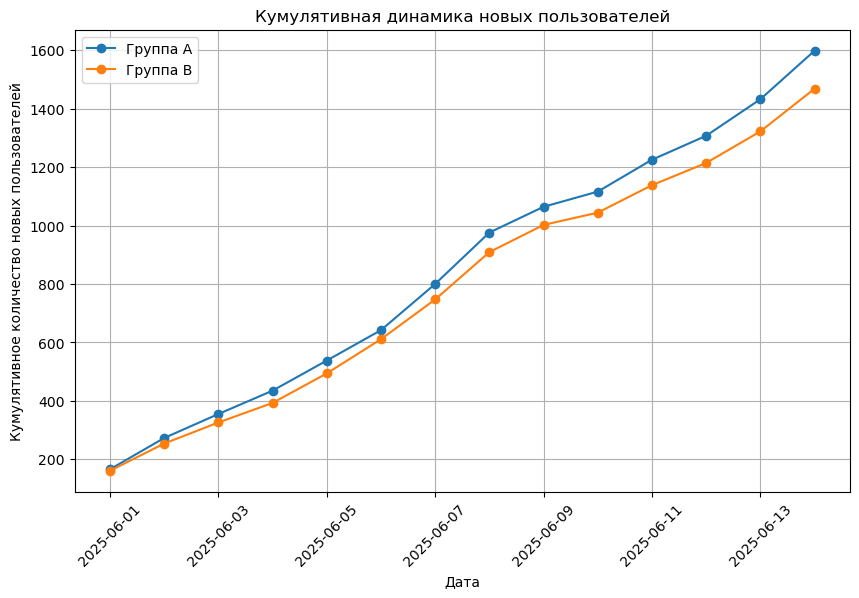

In [8]:
# Группируем данные по дате и группе, получаем ежедневное количество новых пользователей
cumul_users = test_new_users.groupby(['first_date', 'group']).agg({'user_id': 'nunique'}).reset_index()
cumul_users = cumul_users.sort_values('first_date')

# Создаём столбец для накопительных значений
cumul_users['cumul_users'] = 0
for grp in cumul_users['group'].unique():
    temp_sum = 0
    # Получаем индексы строк для текущей группы
    grp_idx = cumul_users['group'] == grp
    # Проходимся по строкам текущей группы
    cum_list = []
    for users in cumul_users.loc[grp_idx, 'user_id']:
        temp_sum += users
        cum_list.append(temp_sum)
    cumul_users.loc[grp_idx, 'cum_users'] = cum_list

# Строим график накопительной динамики новых пользователей по группам
plt.figure(figsize=(10, 6))
for grp in cumul_users['group'].unique():
    grp_data = cumul_users[cumul_users['group'] == grp]
    plt.plot(grp_data['first_date'], grp_data['cum_users'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество новых пользователей')
plt.title('Кумулятивная динамика новых пользователей')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Строим график кумулятивной динамики сессий:

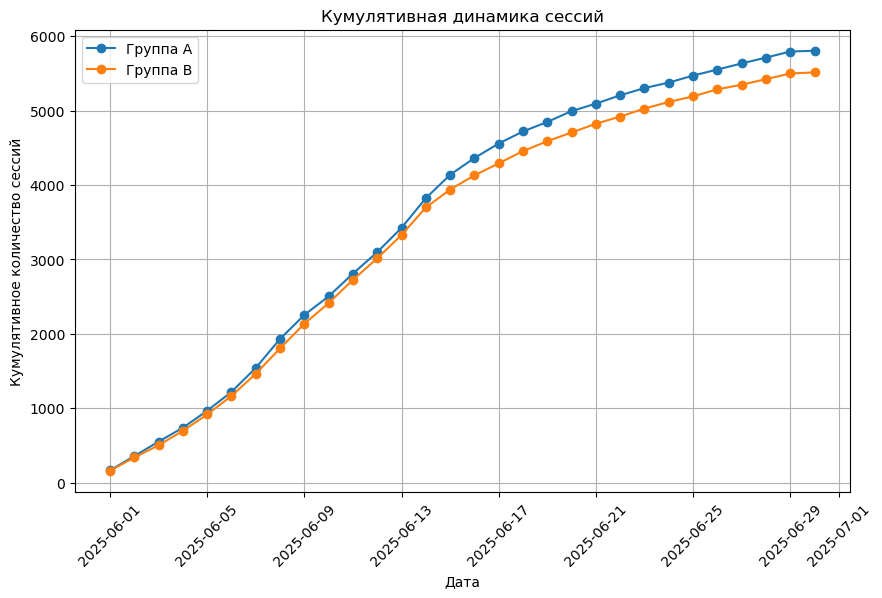

In [9]:
# График кумулятивной динамики сессий
# Группируем данные по дате начала сессии и тестовой группе, считаем количество сессий
cml_sessions = test_sessions.groupby(['session_start', 'group']).size().reset_index(name='session_count')
cml_sessions = cml_sessions.sort_values('session_start')

# Вычисляем кумулятивное количество сессий для каждой группы
cml_sessions['cml_sessions'] = cml_sessions.groupby('group')['session_count'].cumsum()

# Строим график
plt.figure(figsize=(10, 6))
for grp in cml_sessions['group'].unique():
    grp_data = cml_sessions[cml_sessions['group'] == grp]
    plt.plot(grp_data['session_start'], grp_data['cml_sessions'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество сессий')
plt.title('Кумулятивная динамика сессий')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Предварительный вывод по графикам: во всех рассматриваемых метриках (новые пользователи и сессии) результаты группы A немного лучше результатов группы B. Визуально разница не кажется огромной, но она устойчиво сохраняется на протяжении теста.

**2. Ответить на вопросы**

Какая была конверсия в разных группах?

In [10]:
# Посчитаем по группам пользователей, совершивших покупку
purchased_users = test_purchases.groupby('group')['user_id'].nunique()
# Посчитаем общее количество пользователей по группам
total_users = test_new_users.groupby('group')['user_id'].nunique()

# Рассчитаем конверсию
conversion = (purchased_users / total_users).reset_index().rename(columns={0: 'conversion'})
print("\nКонверсия по группам (покупок / регистраций):")
print(conversion)


Конверсия по группам (покупок / регистраций):
  group   user_id
0     A  0.295369
1     B  0.183924


Результаты показывают, что конверсия группы A (29.5%) значительно выше по сравнению с группой B (18.4%). Это может говорить о том, что тестируемый вариант в группе A более эффективен в совершении покупок на основе регистраций

Как выглядит кумулятивная динамика покупок?

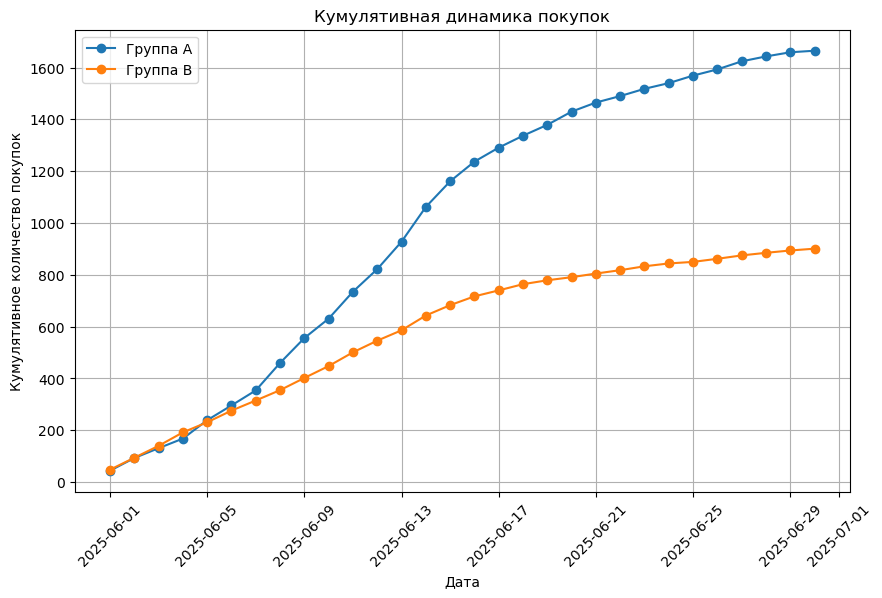

In [11]:
# Группируем данные по дате покупки и тестовой группе, считаем количество покупок
cml_purchases = test_purchases.groupby(['event_dt', 'group']).size().reset_index(name='purchase_count')
cml_purchases = cml_purchases.sort_values('event_dt')

# Вычисляем кумулятивное количество покупок для каждой группы вручную без использования cumsum()
# Создаём столбец для накопительных значений
cml_purchases['cml_purchases'] = 0
for grp in cml_purchases['group'].unique():
    temp_sum = 0
    grp_idx = cml_purchases['group'] == grp
    cum_list = []
    for count in cml_purchases.loc[grp_idx, 'purchase_count']:
        temp_sum += count
        cum_list.append(temp_sum)
    cml_purchases.loc[grp_idx, 'cml_purchases'] = cum_list

# Строим график кумулятивной динамики покупок по группам
plt.figure(figsize=(10, 6))
for grp in cml_purchases['group'].unique():
    grp_data = cml_purchases[cml_purchases['group'] == grp]
    plt.plot(grp_data['event_dt'], grp_data['cml_purchases'], marker='o', label=f'Группа {grp}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное количество покупок')
plt.title('Кумулятивная динамика покупок')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Виден рост у группы А. Для окончательных выводов о статистической значимости этой разницы необходимо проверить метрики с помощью соответствующих статистических тестов (например, z-теста или теста Манна — Уитни), а также убедиться, что тест соответствует всем требованиям технического задания (сроки проведения, достаточный размер выборки и так далее).

### Шаг 3. Проверка гипотез
Проведём z-тест для проверки статистической значимости разницы конверсии между группами (например, между группами A и B).

Почему z-тест?

 - Тип данных — пропорции (конверсии). Когда сравнивают две доли (например, долю пользователей, которые что-либо купили, от общего количества пользователей в каждой группе), классическим инструментом является z-тест для пропорций.
 - Цель — сравнить две независимые выборки. В эксперименте две независимые группы (A и B), и нужно проверить, существует ли между ними статистически значимая разница в доле успехов (конверсии). Для этой задачи z-тест для двух независимых пропорций подходит как нельзя лучше.

In [12]:
groups = list(test_participants['group'].unique())

# Проверяем наличие групп A и B
if 'A' in groups and 'B' in groups:
    # count: количество пользователей, совершивших покупку, в каждой группе
    count = [purchased_users['A'], purchased_users['B']]
    # nobs: общее количество пользователей в каждой группе
    nobs = [total_users['A'], total_users['B']]

    stat, pval = proportions_ztest(count, nobs)
    print(f"\nРезультаты Z-теста для конверсии:\n"
          f"Статистика = {stat:.2f}, p-value = {pval:.3f}")
else:
    print("\nДля проведения Z-теста требуются как минимум группы A и B.")


Результаты Z-теста для конверсии:
Статистика = 7.20, p-value = 0.000


Критерий показывает, что между группами действительно существуют статистически значимые различия.

### Шаг 4. Формулирование выводов и рекомендаций

Сформулировать выводы по результатам тестирования:

 - Был ли тест проведён согласно техническому заданию?
 - Было ли распределение на тестовые группы корректным?
 - Наблюдается ли различие в метрике конверсии между тестовыми группами?

**Выводы:**

 - Тест был проведён в соответствии с ТЗ с небольшими, практически незначительными отклонениями.

 - Между группами наблюдаются статистически значимые различия: у группы А более высокий уровень конверсии в покупку, чем у группы В.

**Рекомендации для заказчика:**

Новая платёжная воронка работает хуже, чем старая. Не рекомендовано её внедрять для всех пользователей.
Конверсия снизилась — можно предположить, что в момент первой покупки у части пользователей возникают технические сложности, и этот момент нужно протестировать.